In [74]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder,StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
from keras.layers import Input, Dense
import tensorflow as tf
import matplotlib
import matplotlib.dates as md
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import torch
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


In [75]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [76]:
# Load the dataset
df = pd.read_csv("C:\\Users\\amirs\\Desktop\\Desktop\\ML Project\\ambient_temperature_system_failure.csv")





In [77]:
df.head()


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [79]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [80]:
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9

In [81]:
fig = px.scatter(x=df['timestamp'], y=df['value'])
fig.show()

In [82]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)


In [83]:
# the day of the week (Monday=0, Sunday=6) and if it's a weekend day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [84]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].view(np.int64)/100000000000).astype(np.int64)

In [85]:
# creation of 4 distinct categories that seem useful ( weekend/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=a,
    histnorm='percent',
    name='WeekEndNight', # name used in legend and hover labels
    marker_color='purple',
    opacity=1,
    
    xbins=dict( # bins used for histogram
    start=14,
    end=30,
    size=0.5
    ),
    
))

fig.add_trace(go.Histogram(
    x=b,
    histnorm='percent',
    name='WeekEndLight',
    marker_color='green',
    opacity=1,

    xbins=dict( # bins used for histogram
    start=14,
    end=30,
    size=0.5
    ),
    
))
fig.add_trace(go.Histogram(
    x=c,
    histnorm='percent',
    name='WeekDayNight',
    marker_color='red',
    opacity=1,

    xbins=dict( # bins used for histogram
    start=14,
    end=30,
    size=0.5
    ),
    
))

fig.add_trace(go.Histogram(
    x=d,
    histnorm='percent',
    name='WeekDayLight',
    marker_color='blue',
    opacity=1,

    xbins=dict( # bins used for histogram
    start=14,
    end=30,
    size=0.5
    ),
    
))


In [86]:
# Step 4: Data Preprocessing and Standardization
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

DATA Splite into Train and Test 

In [87]:
# Step 5: Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split

X = data_scaled  # Your features
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Step 6: Perform Principal Component Analysis (PCA)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_test_pca)
print('//////////////////////////////////////////')
print(X_train_pca)

[[-0.2709621   1.84188461]
 [-1.47311524 -1.1519095 ]
 [ 2.45423538  1.39931817]
 ...
 [-0.8709725  -0.99975278]
 [-0.91956341 -1.10795927]
 [-1.25915404 -0.93063901]]
//////////////////////////////////////////
[[-1.13051109 -0.70206766]
 [-1.07830839 -0.50303716]
 [-0.52578955 -0.30456116]
 ...
 [ 2.00751808 -1.163949  ]
 [-1.4346327  -0.29191108]
 [ 2.16702288  1.23916745]]


Standardizing Data

In [88]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instance
scaler_pca = StandardScaler()
# Fit the scaler to the PCA-transformed training data and transform it
X_train_pca_standardized = scaler_pca.fit_transform(X_train_pca)
# You can also apply the same transformation to the test data
X_test_pca_standardized = scaler_pca.transform(X_test_pca)


Kelbow's Plot to finde No clusters 


c:\Users\amirs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\amirs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\amirs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\amirs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

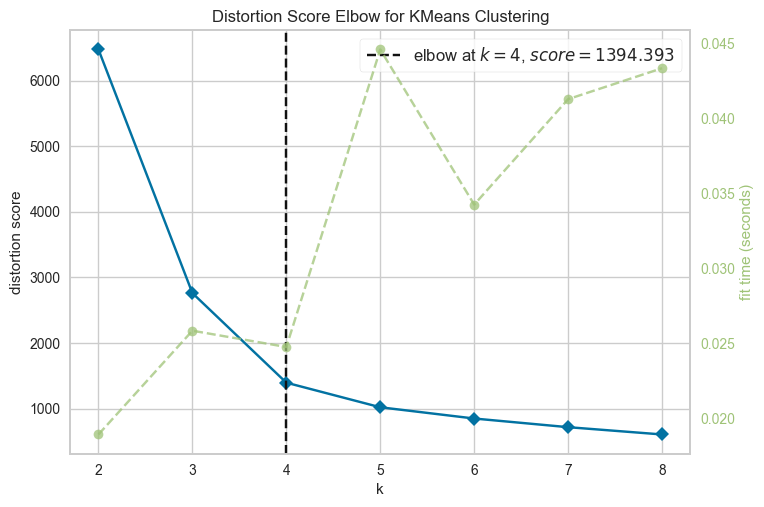

In [89]:

# using Kelbow's Plot to find the number of clusters
elbow = KElbowVisualizer(KMeans(), k=8, random_state=42)
elbow.fit(X_train_pca_standardized)
elbow.show()
plt.show()

Creating Cluster Label for Data

In [90]:
from sklearn.cluster import KMeans
# Create a K-Means model with the optimal number of clusters (n_clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
# Fit the model to your standardized PCA-transformed training data
kmeans.fit(X_train_pca_standardized)
# Predict cluster labels for both training and test data
train_cluster_labels = kmeans.predict(X_train_pca_standardized)
test_cluster_labels = kmeans.predict(X_test_pca_standardized)
df_train = pd.DataFrame(X_train_pca_standardized)
# Add a new column to store the cluster labels
df_train['Cluster'] = train_cluster_labels
df_train.head()


c:\Users\amirs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,0,1,Cluster
0,-0.829138,-0.550332,1
1,-0.790852,-0.394317,1
2,-0.385624,-0.238737,1
3,1.786324,-1.203307,0
4,-1.225736,0.049998,1


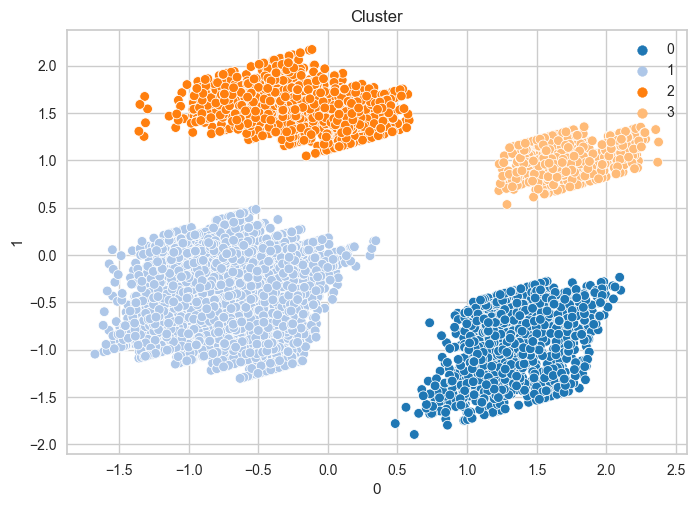

In [91]:
pl = sns.scatterplot(data = df_train,x=df_train[0], y=df_train[1],hue=df_train["Cluster"], palette="tab20")
pl.set_title("Cluster")
plt.legend()
plt.show()

Dedecting Anomaly By Kmeans 

In [92]:
distances = kmeans.transform(df_train.drop("Cluster", axis=1))
closest_cluster_distances = np.min(distances, axis=1)

# Determine the threshold value for the distances
threshold = np.percentile(closest_cluster_distances, 95)

# Identify the anomalies or outliers
anomalies = df_train[closest_cluster_distances > threshold]

# Add a new column to the data indicating whether each data point is an anomaly or not
df_train["anomaly_db"] = 0
df_train.loc[anomalies.index, "anomaly_db"] = 1


In [93]:
df_train.head()


,0,1,Cluster,anomaly_db
0,-0.829138,-0.550332,1,0
1,-0.790852,-0.394317,1,0
2,-0.385624,-0.238737,1,0
3,1.786324,-1.203307,0,0
4,-1.225736,0.049998,1,0


Ploting Kmeans

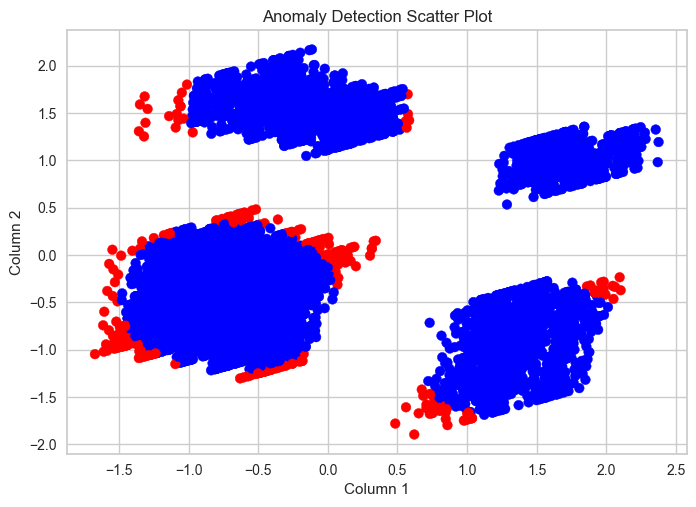

In [94]:
plt.scatter(df_train[0], df_train[1], c=df_train['anomaly_db'].map({1: 'red', 0: 'blue'}))
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Anomaly Detection Scatter Plot')
plt.show()

Evaluating the Model


In [95]:
silhouette_avg = silhouette_score(df_train.drop(['Cluster', 'anomaly_db'], axis=1), df_train['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6759832961854856


KNN Model

In [96]:
from sklearn.neighbors import NearestNeighbors
df_train.columns = df_train.columns.astype(str)
# Fit a KNN model to the data
knn = NearestNeighbors(n_neighbors=5)
knn.fit(df_train)
distances, _ = knn.kneighbors()
# Calculate the threshold for anomaly detection
threshold = np.percentile(distances[:, -1], 99)
# Create an 'anomaly_knn' column based on the threshold
df_train['anomaly_knn'] = np.where(distances[:, -1] > threshold, 1, 0)



Ploting KNN

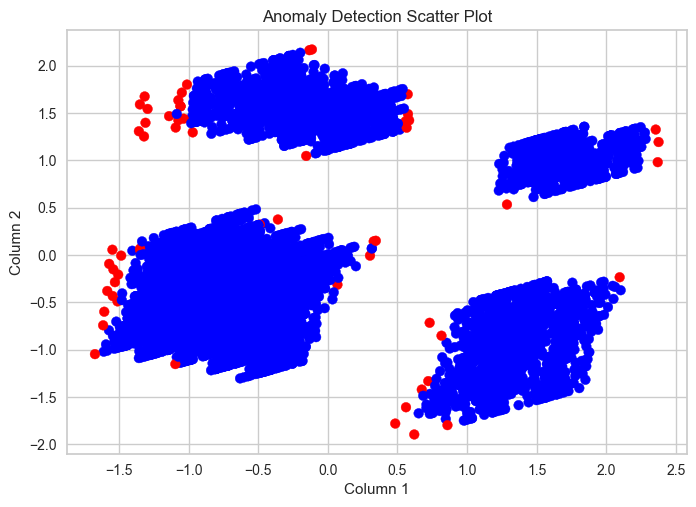

In [97]:
plt.scatter(df_train['0'], df_train['1'], c=df_train['anomaly_knn'].map({1: 'red', 0: 'blue'}))
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Anomaly Detection Scatter Plot')
plt.show()

Evaluating

In [98]:
silhouette_avg = silhouette_score(df_train.drop(['Cluster', 'anomaly_knn'], axis=1), df_train['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6592168299844645


SVM Model

In [99]:
from sklearn.svm import OneClassSVM
# One-Class SVM for Anomaly Detection
svm_model = OneClassSVM(nu=0.02, kernel="rbf", gamma='auto')
df_train['anomaly_svm'] = svm_model.fit_predict(df_train)

Visuaize SVM

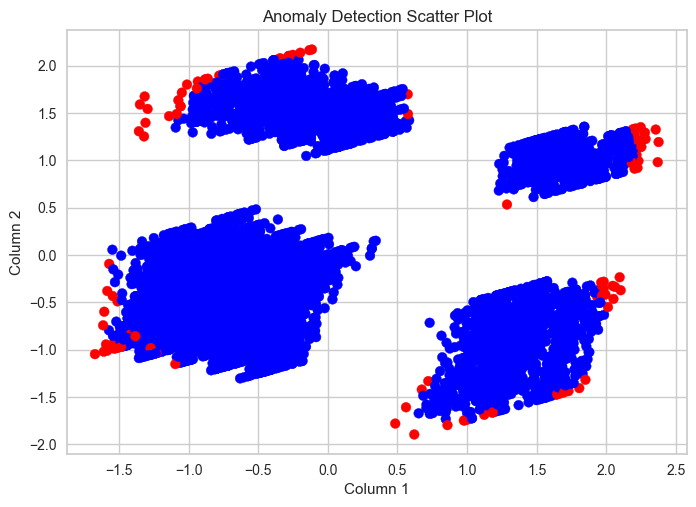

In [100]:
# Map labels to colors
colors = df_train['anomaly_svm'].map({1: 'blue', -1: 'red'})
plt.scatter(df_train['0'], df_train['1'], c=colors)
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.title('Anomaly Detection Scatter Plot')
plt.show()

Evaluating 

In [101]:
silhouette_avg = silhouette_score(df_train.drop(['Cluster', 'anomaly_svm'], axis=1), df_train['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.656948637140819


Meanshift_Clustring

In [102]:
from sklearn.cluster import MeanShift

# Create a MeanShift clustering model
bandwidth = 0.5
ms = MeanShift(bandwidth=bandwidth)

# Fit the MeanShift model to your reduced-dimensional training data
ms.fit(X_train_pca_standardized)

# Identify cluster centers
cluster_centers = ms.cluster_centers_

# Label data points
labels_train = ms.predict(X_train_pca_standardized)
labels_test = ms.predict(X_test_pca_standardized)

df_train = pd.DataFrame(X_train_pca_standardized)
# Add a new column to store the cluster labels
df_train['ClusterMeanShift'] = labels_train

df_test = pd.DataFrame(X_test_pca_standardized)
df_test['ClusterMeanShift'] = labels_test

Visulize meanshift Clusters

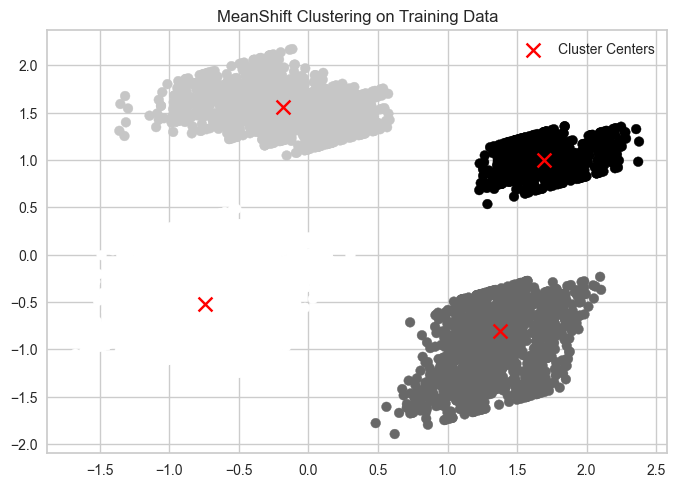

In [103]:
import matplotlib.pyplot as plt

# Visualize the results for training data
plt.scatter(df_train[0], df_train[1], c=labels_train)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='red', marker='x', label='Cluster Centers')
plt.legend()
plt.title('MeanShift Clustering on Training Data')
plt.show()



Identify anomalies by Meanshift

In [104]:
from sklearn.metrics import pairwise_distances

# Calculate the distance from each data point to its nearest cluster center
distances_train = pairwise_distances(X_train_pca_standardized, cluster_centers)
min_distances_train = np.min(distances_train, axis=1)

distances_test = pairwise_distances(X_test_pca_standardized, cluster_centers)
min_distances_test = np.min(distances_test, axis=1)

# Set a threshold on the distance to identify anomalies
threshold = 1
anomalies_train = min_distances_train > threshold
anomalies_test = min_distances_test > threshold

# Add the anomaly labels to the data frames
df_train['mainshiftAnomally'] = anomalies_train
df_test['mainshiftAnomally'] = anomalies_test

# Print or further process the anomalies as needed
print("Anomalies in Training Data:")
print(anomalies_train)

print("Anomalies in Test Data:")
print(anomalies_test)


Anomalies in Training Data:
[False False False ... False False False]
Anomalies in Test Data:
[False False False ... False False False]


Visualize anomalies by Meanshift.

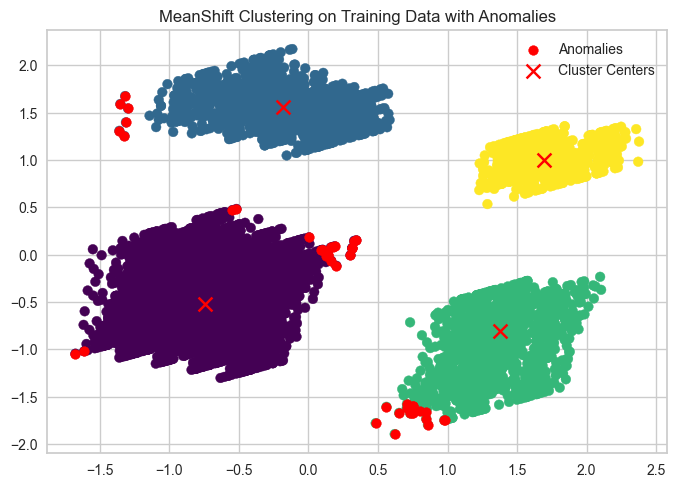

In [105]:
# Visualize the training data with anomalies
plt.scatter(df_train[0], df_train[1], c=labels_train, cmap='viridis')  # Plot data points with cluster labels
plt.scatter(df_train[0][anomalies_train], df_train[1][anomalies_train], c='red', marker='o', label='Anomalies')  # Highlight anomalies in red
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, c='red', marker='x', label='Cluster Centers')
plt.legend()
plt.title('MeanShift Clustering on Training Data with Anomalies')
plt.show()



In [106]:
meanshift_silhouette_avg = silhouette_score(X_train_pca_standardized, labels_train)
print("MeanShift Silhouette Score:", meanshift_silhouette_avg)



MeanShift Silhouette Score: 0.6759832961854856


In [107]:
# Define the input layer
input_layer = Input(shape=(2,))  # Assuming 2 principal components from PCA

# Define the encoder part
encoded = Dense(4, activation='relu')(input_layer)  # Adjust the number of units as needed

# Define the decoder part
decoded = Dense(2, activation='linear')(encoded)  # Output layer with linear activation

# Create the autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile the model (you can adjust the loss and optimizer as needed)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Train the autoencoder
autoencoder.fit(X_train_pca_standardized, X_train_pca_standardized, epochs=100, batch_size=128, shuffle=True, validation_data=(X_test_pca_standardized, X_test_pca_standardized))
# Predict on the training and test data
train_predictions = autoencoder.predict(X_train_pca_standardized)
test_predictions = autoencoder.predict(X_test_pca_standardized)

# Calculate the reconstruction errors
train_mse = np.mean(np.square(X_train_pca_standardized - train_predictions), axis=1)
test_mse = np.mean(np.square(X_test_pca_standardized - test_predictions), axis=1)

# Set a threshold for anomaly detection (adjust as needed)
#anomaly_threshold = np.percentile(train_mse, 95) 

anomaly_threshold =train_mse.mean() + 3 * train_mse.std()
df_train['anomaly_rb'] = (train_mse > anomaly_threshold).astype(int)
# Detect anomalies in both training and test data
train_anomalies = train_mse > anomaly_threshold
test_anomalies = test_mse > anomaly_threshold


Epoch 1/100
46/46 [==============================] - 0s 2ms/step - loss: 1.1080 - val_loss: 1.0128
Epoch 2/100
46/46 [==============================] - 0s 1ms/step - loss: 0.9179 - val_loss: 0.8351
Epoch 3/100
46/46 [==============================] - 0s 1ms/step - loss: 0.7520 - val_loss: 0.6792
Epoch 4/100
46/46 [==============================] - 0s 1ms/step - loss: 0.6056 - val_loss: 0.5412
Epoch 5/100
46/46 [==============================] - 0s 1ms/step - loss: 0.4764 - val_loss: 0.4202
Epoch 6/100
46/46 [==============================] - 0s 1ms/step - loss: 0.3649 - val_loss: 0.3177
Epoch 7/100
46/46 [==============================] - 0s 1ms/step - loss: 0.2725 - val_loss: 0.2351
Epoch 8/100
46/46 [==============================] - 0s 1ms/step - loss: 0.1995 - val_loss: 0.1715
Epoch 9/100
46/46 [==============================] - 0s 1ms/step - loss: 0.1447 - val_loss: 0.1249
Epoch 10/100
46/46 [==============================] - 0s 1ms/step - loss: 0.1058 - val_loss: 0.0929
Epoch 11/

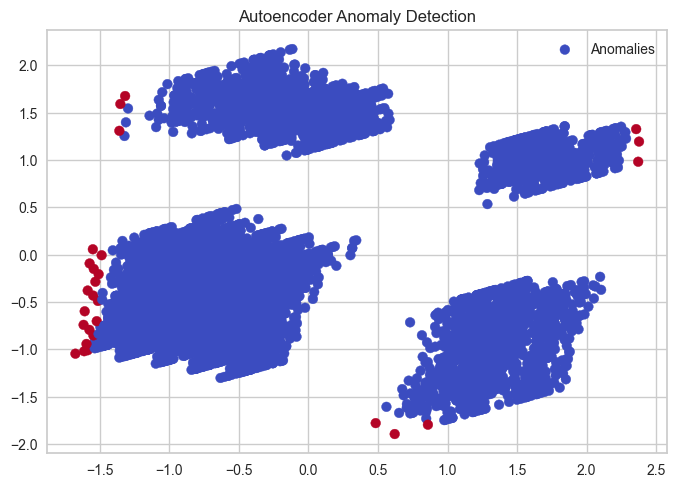

In [108]:
plt.scatter(df_train[0], df_train[1], c=train_anomalies, cmap='coolwarm', marker='o', label='Anomalies')
plt.title('Autoencoder Anomaly Detection')
plt.legend()
plt.show()

In [109]:
# Calculate MSE
mse_train = np.mean(np.square(X_train_pca_standardized - train_predictions))
mse_test = np.mean(np.square(X_test_pca_standardized - test_predictions))
print("Autoencoder Mean Squared Error (MSE) on Train Data:", mse_train)
print("Autoencoder Mean Squared Error (MSE) on Test Data:", mse_test)

Autoencoder Mean Squared Error (MSE) on Train Data: 0.00010631727990368933
Autoencoder Mean Squared Error (MSE) on Test Data: 0.00012022812273046613
